In [42]:
import os
import pandas
from tabulate import tabulate
#去powershell download

In [43]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import networkx

In [44]:
class GameHistory():
    def __init__(self, game_dimension=(19, 19), game_players=6, game_members=8):
        self.game_history_folder = 'C:\\Users\\user\\anaconda3\\Projects\\BizCases\\SurvivalGame'
        self.game_dimension = game_dimension
        self.game_players = 6
        self.game_members = 8
        self.game_history = None

    def get_game_history(self):
        game_history_csv = '%s/GameHistory/GAME-%d-%d.csv' % (
            self.game_history_folder, self.game_players, self.game_members)

        if not os.path.exists(game_history_csv):
            my_logger.error('%s 檔案不存在' % game_history_csv)
            self.game_history = None
            return None

        self.game_history = pandas.read_csv(game_history_csv, header=0, encoding='utf8')
        self.game_history.sort_values(by=['epoch', 'player'], inplace=True)

        return self.game_history
    
    def game_history_exists(self):
        return self.game_history is not None
    
    def get_game_last_epoch(self):
        _last_epoch = -1
        
        if self.game_history_exists():
            _last_epoch = self.game_history['epoch'].unique().max()
            
        return _last_epoch
    
    def get_game_epoch(self, my_game_epoch=0):
        return self.game_history.loc[self.game_history['epoch'] == my_game_epoch]
    
    def get_game_survivor_left(self, my_game_survivor_left=1):
        _game_epochs = sorted(self.game_history['epoch'].unique())
        
        for _game_epoch in _game_epochs:
            _survivor_left = self.game_history.loc[self.game_history['epoch'] == _game_epoch].count()
            
            if _survivor_left.values[0] == my_game_survivor_left:
                return self.game_history.loc[self.game_history['epoch'] == _game_epoch]
            
        return None
    
    def output_game_history(self, my_game_history):
        if my_game_history.empty:
            return
        
        print(tabulate(my_game_history[['epoch', 'player', 'x', 'y', 'weight']], 
               headers=['世代', '玩家', '座標-X', '座標-Y', '權重'], showindex=False))

In [49]:
class PlotGameNeowrks(GameHistory):
    def __init__(self, game_dimension=(19, 19), game_players=6, game_members=8):
        GameHistory.__init__(self, game_dimension, game_players, game_members)
        self.plot_font = font_manager.FontProperties(fname='C:/Windows/Fonts/simsun.ttc', size=10)    #依照存活隊伍數繪圖
    def plot_board_by_survivor_left(self, my_game_survivor_left=1):
        my_game_epoch_history = self.get_game_survivor_left(my_game_survivor_left)
        my_game_players_names = self.game_history['player'].unique()
        my_game_epoch = my_game_epoch_history['epoch'].values[0]

        fig, ax = plt.subplots(dpi=120, figsize=(4, 4))#圖畫紙
        #設定值域
        ax.set_xlim(0, self.game_dimension[0])#長
        ax.set_ylim(0, self.game_dimension[1])#寬
        #設定顯示值為整數
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        
        text_style = dict(size=10, color='gray')#繪圖字型大小及顏色

        for player_id in range(len(my_game_players_names)):
            current_game_player = my_game_players_names[player_id]#一個一個跑player的名字
            my_game_epoch_history_player = my_game_epoch_history.loc[my_game_epoch_history['player'] == current_game_player].copy()#個別印出player的整筆資料

            if my_game_epoch_history_player.shape[0] == 0:
                continue
            #設計圖上的點
            ax.scatter(my_game_epoch_history_player['x'],
                       my_game_epoch_history_player['y'],
                       marker=player_id,
                       s=20 * my_game_epoch_history_player['weight'],
                       label=current_game_player)
            
            for i in range(my_game_epoch_history_player.shape[0]):
                _row = my_game_epoch_history_player.iloc[i] #一筆一筆的資料
                _x = _row['x']
                _y = _row['y']
                _s = str(_row['member'])

                ax.text(_x, _y, _s, **text_style)

        ax.legend(loc='best', prop=self.plot_font)
        ax.grid(True)
        
        #匯出png檔
        game_history_png = '%s/GamePlots/GAME-%d-%d-%03d.png' % (
            self.game_history_folder, self.game_players, self.game_members, my_game_epoch)
        
        fig.savefig(game_history_png)
        fig.clf()
        plt.close(fig)
    
    #依照世代繪圖
    def plot_board_by_epoch(self, my_game_epoch=0):
        my_game_epoch_history = self.game_history.loc[self.game_history['epoch'] == my_game_epoch].copy()
        my_game_players_names = self.game_history['player'].unique()

        fig, ax = plt.subplots(dpi=120, figsize=(4, 4))

        ax.set_xlim(0, self.game_dimension[0])
        ax.set_ylim(0, self.game_dimension[1])

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        text_style = dict(size=10, color='gray')

        for player_id in range(len(my_game_players_names)):
            current_game_player = my_game_players_names[player_id]
            my_game_epoch_history_player = my_game_epoch_history.loc[my_game_epoch_history['player'] == current_game_player].copy()

            if my_game_epoch_history_player.shape[0] == 0:
                continue

            ax.scatter(my_game_epoch_history_player['x'],
                       my_game_epoch_history_player['y'],
                       marker=player_id,
                       s=20 * my_game_epoch_history_player['weight'],
                       label=current_game_player)

            for i in range(my_game_epoch_history_player.shape[0]):
                _row = my_game_epoch_history_player.iloc[i]
                _x = _row['x']
                _y = _row['y']
                _s = str(_row['member'])

                ax.text(_x, _y, _s, **text_style)

        ax.legend(loc='best', prop=self.plot_font)
        ax.grid(True)

        game_history_png = '%s/GamePlots/GAME-%d-%d-%03d.png' % (
            self.game_history_folder, self.game_players, self.game_members, epoch)
        
        fig.savefig(game_history_png)
        fig.clf()
        plt.close(fig)
    def get_epoch_graph(self, my_game_epoch=0):
        _subset = self.get_game_epoch(my_game_epoch).sort_values(by=['player'])

        _players = sorted(_subset['player'].unique())
        _members = sorted(_subset['member'].unique())

        G = networkx.Graph()

        for player in _players:
            G.add_edge('Epoch-%d' % my_game_epoch, player)

            for member in _members:
                _node_id = '%s-%d' % (player, member)
                _subset2 = _subset.loc[(_subset['player'] == player) & (_subset['member'] == member)]
                
                G.add_edge(player, _node_id)

                networkx.set_node_attributes(G, {
                    _node_id: {'x': _subset2['x'].values, 
                               'y': _subset2['y'].values, 
                               'weight': _subset2['weight'].values}
                })


        return G   
    def get_survivor_left_by_graph(self):
        game_networks = dict()
        
        for epoch in sorted(self.game_history['epoch'].unique()):
            _G = self.get_epoch_graph(epoch)

            for node_id, num_of_edges in _G.degree():
                if node_id == 'Epoch-%d' % (epoch):
                    if num_of_edges not in game_networks:
                        game_networks[num_of_edges] = [epoch, _G]

        return game_networks
    def get_game_history_by_grpah(self, game_epoch_networks):
        for node in game_epoch_networks[1].nodes(data=True):
            if 'weight' in node[1]:
                if len(node[1]['weight']) > 0:
                    print('%s (%2d, %2d): %d' % (node[0], node[1]['x'][0], node[1]['y'][0], node[1]['weight'][0]))
    def plot_graph(self, game_graph):
        fig, ax = plt.subplots(dpi=120, figsize=(8, 8))
        networkx.draw(game_graph, ax=ax, 
                      font_family=[self.plot_font.get_name()], 
                      with_labels=True)
        plt.show()

   0	6
  40	4
  84	3
 232	2
 539	1


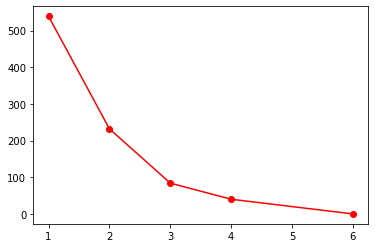

In [50]:
if __name__ == '__main__':
    worker = PlotGameNeowrks(game_dimension=(19, 19),
                             game_players=6,
                             game_members=8)
    
    game_history = worker.get_game_history()
    
    game_networks = worker.get_survivor_left_by_graph()
    
    a=[]
    b=[]
    for survivor_left in game_networks:
        survivor_info = game_networks[survivor_left]      
        print('%4d\t%d' % (survivor_info[0], survivor_left))
        a.append(survivor_left)
        b.append(survivor_info[0])
    plt.plot(a,b,'o-',color='r')
    plt.show()